In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score

In [2]:
# ========================
# 1. Load & Preprocess Data (Discharge and Charge)
# ========================
discharge_file = r"C:\Users\bramb\OneDrive - Stanford\Desktop\CHEM ENG 277\Copy of Oxford_battery_data_discharge.csv"
charge_file = r"C:\Users\bramb\OneDrive - Stanford\Desktop\CHEM ENG 277\Copy of Oxford_battery_data_charge.csv"
OCV_discharge_file = r"C:\Users\bramb\OneDrive - Stanford\Desktop\CHEM ENG 277\Copy of Oxford_battery_data_OCVdc.csv"
OCV_charge_file = r"C:\Users\bramb\OneDrive - Stanford\Desktop\CHEM ENG 277\Copy of Oxford_battery_data_OCVch.csv"

# Load datasets
discharge_data = pd.read_csv(discharge_file, low_memory=False) #Constant-curent-constant-voltage (CC-CV) data
charge_data = pd.read_csv(charge_file, low_memory=False)
OCV_discharge_data = pd.read_csv(OCV_discharge_file, low_memory=False) #Open circuit voltage (OCV) data
OCV_charge_data = pd.read_csv(OCV_charge_file, low_memory=False)

# Sort datasets by cycle order
#discharge_data = discharge_data.sort_values(by=['cell_number', 'cycle_number', 'time'])
#charge_data = charge_data.sort_values(by=['cell_number', 'cycle_number', 'time'])

# Print total rows in each dataset
print(f"Total discharge rows: {len(discharge_data)}")
print(f"Total charge rows: {len(charge_data)}")

# Ensure current values are negative for discharge
if discharge_data['current'].max() > 0:
    discharge_data['current'] = -discharge_data['current']

# Assume 1 second has passed between each row (based on data collection method provided by Birkl's README) 
discharge_data['time_diff'] = 1
charge_data['time_diff'] = 1

# Compute discharge capacity incrementally
discharge_data['incremental_discharge'] = (discharge_data['current'] * discharge_data['time_diff']).abs() / 3600
discharge_data['discharge_capacity'] = discharge_data.groupby(['cell_number', 'cycle_number'])['incremental_discharge'].cumsum() * 1000

Total discharge rows: 1610378
Total charge rows: 1551571


In [3]:
# Combine Charge & Discharge for Continuous Timeline
# Add a column to indicate whether it's a charge or discharge cycle
discharge_data['type'] = 'discharge'
charge_data['type'] = 'charge'
OCV_discharge_data['type'] = 'discharge'
OCV_charge_data['type'] = 'charge'

# Combine both datasets into one continuous time series
full_data = pd.concat([discharge_data, charge_data]).sort_values(by=['cell_number', 'cycle_number', 'time'])
OCV_full_data = pd.concat([OCV_discharge_data, OCV_charge_data]).sort_values(by=['cell_number', 'cycle_number', 'time'])

# Re-index time to reflect a continuous sequence within each cycle
full_data['time'] = full_data.groupby(['cell_number', 'cycle_number']).cumcount()
OCV_full_data['time'] = OCV_full_data.groupby(['cell_number', 'cycle_number']).cumcount()

# Print sample time alignment check
print("\n Sample Time Alignment Check for CC-CV data:")
for cell in discharge_data['cell_number'].unique()[:3]:
    discharge_cycles = discharge_data[discharge_data['cell_number'] == cell]['cycle_number'].unique()
    charge_cycles = charge_data[charge_data['cell_number'] == cell]['cycle_number'].unique()
    print(f"Cell {cell}: {len(discharge_cycles)} discharge cycles, {len(charge_cycles)} charge cycles")

print("\n Sample Time Alignment Check for OCV data:")
for cell in OCV_discharge_data['cell_number'].unique()[:3]:
    OCV_discharge_cycles = OCV_discharge_data[OCV_discharge_data['cell_number'] == cell]['cycle_number'].unique()
    OCV_charge_cycles = OCV_charge_data[OCV_charge_data['cell_number'] == cell]['cycle_number'].unique()
    print(f"Cell {cell}: {len(OCV_discharge_cycles)} discharge cycles, {len(OCV_charge_cycles)} charge cycles")


 Sample Time Alignment Check for CC-CV data:
Cell 1: 78 discharge cycles, 78 charge cycles
Cell 2: 73 discharge cycles, 73 charge cycles
Cell 3: 76 discharge cycles, 76 charge cycles

 Sample Time Alignment Check for OCV data:
Cell 1: 78 discharge cycles, 78 charge cycles
Cell 2: 73 discharge cycles, 73 charge cycles
Cell 3: 76 discharge cycles, 76 charge cycles


In [4]:
# ========================
# 3. Remove Unrealistic Temperature Values
# ========================
full_data_filtered = full_data[full_data['temperature'] >= 35].copy()

# Print temperature check
print("\n Temperature Data Summary Before Aggregation:")
print(full_data_filtered['temperature'].describe())



 Temperature Data Summary Before Aggregation:
count    3.155405e+06
mean     4.067166e+01
std      6.519175e-01
min      3.743604e+01
25%      4.020629e+01
50%      4.058188e+01
75%      4.109366e+01
max      4.290186e+01
Name: temperature, dtype: float64


In [5]:
# Compute Voltage Hysteresis (this one is using the CC-CV data) 

hysteresis_df = full_data_filtered.pivot_table(index=['cell_number', 'cycle_number'],
                                               columns='type',
                                               values='voltage',
                                               aggfunc='mean')

# Compute hysteresis feature
hysteresis_df['hysteresis_voltage'] = hysteresis_df['charge'] - hysteresis_df['discharge']
hysteresis_df.reset_index(inplace=True)

# Print hysteresis voltage values
print("\n Sample Hysteresis Voltage Values:")
print(hysteresis_df[['cell_number', 'cycle_number', 'hysteresis_voltage']].head(10))


 Sample Hysteresis Voltage Values:
type  cell_number  cycle_number  hysteresis_voltage
0               1             1            0.084588
1               1             2            0.086035
2               1             3            0.085967
3               1             4            0.086419
4               1             5            0.086140
5               1             6            0.086546
6               1             7            0.086902
7               1             8            0.087596
8               1             9            0.087943
9               1            10            0.088390


In [6]:
# Compute Voltage Hysteresis (OCV data) 
OCV_hysteresis_df = OCV_full_data.pivot_table(index=['cell_number', 'cycle_number'],
                                               columns='type',
                                               values='voltage',
                                               aggfunc='mean')

# Compute hysteresis feature
OCV_hysteresis_df['hysteresis_voltage'] = OCV_hysteresis_df['charge'] - OCV_hysteresis_df['discharge']
OCV_hysteresis_df.reset_index(inplace=True)

# Print hysteresis voltage values
print("\n Sample Hysteresis Voltage Values (OCV):")
print(OCV_hysteresis_df[['cell_number', 'cycle_number', 'hysteresis_voltage']].head(10))


 Sample Hysteresis Voltage Values (OCV):
type  cell_number  cycle_number  hysteresis_voltage
0               1             1            0.024242
1               1             2            0.024563
2               1             3            0.024360
3               1             4            0.024416
4               1             5            0.024378
5               1             6            0.024543
6               1             7            0.024527
7               1             8            0.024697
8               1             9            0.024985
9               1            10            0.025060


In [7]:
# ========================
# 5. Aggregate Features for SOH Calculation
# ========================
agg_funcs = {
    'voltage': 'mean',
    'temperature': 'mean',
    'discharge_capacity': 'max'
}

grouped_CC_CV = full_data_filtered.groupby(['cell_number', 'cycle_number']).agg(agg_funcs).reset_index()
grouped_OCV = full_data_filtered.groupby(['cell_number', 'cycle_number']).agg(agg_funcs).reset_index()

# Rename columns for clarity
grouped_CC_CV.rename(columns={
    'voltage': 'avg_voltage',
    'temperature': 'avg_temperature',
    'discharge_capacity': 'max_discharge_capacity'
}, inplace=True)

grouped_OCV.rename(columns={
    'voltage': 'avg_voltage',
    'temperature': 'avg_temperature',
    'discharge_capacity': 'max_discharge_capacity'
}, inplace=True)

# Merge with hysteresis data
grouped_CC_CV = pd.merge(grouped_CC_CV, hysteresis_df[['cell_number', 'cycle_number', 'hysteresis_voltage']],
                   on=['cell_number', 'cycle_number'], how='left')

grouped_OCV = pd.merge(grouped_OCV, OCV_hysteresis_df[['cell_number', 'cycle_number', 'hysteresis_voltage']],
                   on=['cell_number', 'cycle_number'], how='left')


In [8]:
# ========================
# 6. Compute State of Health (SOH)
# ========================
def compute_soh(df):
    cycle_1_capacity = df.loc[df['cycle_number'] == 1, 'max_discharge_capacity']
    if cycle_1_capacity.empty or cycle_1_capacity.values[0] <= 0:
        df['SOH'] = np.nan
        df['SOH Scaled'] = np.nan
    else:
        baseline = cycle_1_capacity.values[0]
        df['SOH'] = (df['max_discharge_capacity'] / baseline) * 100
        df['SOH Scaled'] = (df['max_discharge_capacity'] / baseline) * 100 -100
    return df

grouped_CC_CV = grouped_CC_CV.groupby('cell_number', group_keys=False).apply(compute_soh).dropna(subset=['SOH'])
grouped_CC_CV = grouped_CC_CV.groupby('cell_number', group_keys=False).apply(compute_soh).dropna(subset=['SOH Scaled'])
grouped_OCV = grouped_OCV.groupby('cell_number', group_keys=False).apply(compute_soh).dropna(subset=['SOH'])
grouped_OCV = grouped_OCV.groupby('cell_number', group_keys=False).apply(compute_soh).dropna(subset=['SOH Scaled'])

# Print SOH check
# print("\n Checking SOH Computation:")
# print(grouped_CC_CV[['cell_number', 'cycle_number', 'max_discharge_capacity', 'hysteresis_voltage', 'SOH', 'SOH Scaled']].head(10))
# print(grouped_CC_CV[['cell_number', 'cycle_number', 'max_discharge_capacity', 'hysteresis_voltage', 'SOH', 'SOH Scaled']].tail(10))
# print("\n")
# print(grouped_OCV[['cell_number', 'cycle_number', 'max_discharge_capacity', 'hysteresis_voltage', 'SOH', 'SOH Scaled']].head(10))
# print(grouped_OCV[['cell_number', 'cycle_number', 'max_discharge_capacity', 'hysteresis_voltage', 'SOH', 'SOH Scaled']].tail(10))

C:\Users\bramb\AppData\Local\Temp\ipykernel_10560\55483438.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_CC_CV = grouped_CC_CV.groupby('cell_number', group_keys=False).apply(compute_soh).dropna(subset=['SOH'])
C:\Users\bramb\AppData\Local\Temp\ipykernel_10560\55483438.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_CC_CV = grouped_CC_CV.groupby('cell_number', group_keys=False).ap

In [9]:
#Define Features & Labels
features = ['avg_voltage', 'avg_temperature', 'cycle_number', 'hysteresis_voltage']
X = grouped_OCV[features].values
y = grouped_OCV['SOH'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
#Time-Based Train/Test Split for Linear Regression model
grouped_sorted = grouped_OCV.sort_values(by=['cell_number', 'cycle_number'])
X_seq = grouped_sorted[features].values
y_seq = grouped_sorted['SOH'].values
X_seq_scaled = scaler.transform(X_seq)

split_index = int(0.8 * len(X_seq_scaled))
X_train, X_test = X_seq_scaled[:split_index], X_seq_scaled[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]


In [11]:
#Train Linear Regression model 
models = {
    "Linear Regression": linear_model.LinearRegression()
}

print("\n--- Model Performance on Time-Based Train/Test Split (80/20) ---")
print("\nFeatures: ['avg_voltage', 'avg_temperature', 'cycle_number', 'hysteresis_voltage']\n")

for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name}:")
    
    model.fit(X_train, y_train)  #Train regression model 
    y_pred = model.predict(X_test)  #Predictions
    y_train_pred = model.predict(X_train)

    #Obtain fitting metrics
    #print(f"  R2 on Training Set = {model.score(X_train, y_train):.4f}")
    #print(f"  R2 on Test Set = {model.score(X_test, y_test):.4f}")
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred) #RMSE Calculation
    mse = mean_squared_error(y_test, y_pred) #Mean squared error 
    mae = mean_absolute_error(y_test, y_pred) #Mean absolute error
    
    #Print out evaluation metrics 
    print(f"  Train R2: {train_r2:.4f}")
    print(f"  Test R2: {test_r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print("  Coefficients", model.coef_)
    print("  Intercept:", model.intercept_)
    print("\n")



--- Model Performance on Time-Based Train/Test Split (80/20) ---

Features: ['avg_voltage', 'avg_temperature', 'cycle_number', 'hysteresis_voltage']

Linear Regression:
  Train R2: 0.9813
  Test R2: 0.9657
  RMSE: 1.9757
  MSE: 3.9035
  MAE: 1.4223
  Coefficients [-4.31373541 -0.03758847 -5.95245578 -3.41553732]
  Intercept: 75.63101659236857




In [36]:
# k-Fold Cross Validation using GroupKFold to estimate the performance of Linear Regression.

# We use k = 4. 
# With 8 battery cells, a 4-fold split yields 2 cells per test fold (~25%).

gkf = GroupKFold(n_splits=4) #Generate four different test/train splits 
fold = 1
groups = grouped_sorted['cell_number'] #There are 8 cells, so make 8 groups
train_r2, test_r2, rmse_fold, mse_fold, mae_fold = [], [], [], [], []

print("\nGroupKFold Cross Validation using Linear Regression (k=4):")

for train_idx, test_idx in gkf.split(X, y, groups): #Each fold considers different cells for test/train sets
    
    X_train_fold, X_test_fold = X[train_idx], X[test_idx]
    y_train_fold, y_test_fold = y[train_idx], y[test_idx]
    
    model = linear_model.LinearRegression() #Fit linear regression model on training data
    model.fit(X_train_fold, y_train_fold) 
    y_train_pred_fold = model.predict(X_train_fold) #Predicted y-values for training set
    y_pred_fold = model.predict(X_test_fold) #Predicted y-values for test set
    
    #train_r2.append(model.score(X_train_fold, y_train_pred_fold)) 
    #test_r2.append(model.score(X_test_fold, y_pred_fold)) #R^2 for training data
    train_r2.append(r2_score(y_train_fold, y_train_pred_fold))
    test_r2.append(r2_score(y_test_fold, y_pred_fold))#R^2 for test data
    rmse_fold.append(root_mean_squared_error(y_test_fold, y_pred_fold)) #Root mean squared error (for test data)
    mse_fold.append(mean_squared_error(y_test_fold, y_pred_fold)) #Mean squared error (for test data)
    mae_fold.append(mean_absolute_error(y_test_fold, y_pred_fold)) #Mean absolute error (for test data)
    
    #Print out test/train groups and metrics 
    train_groups = np.unique(grouped_sorted.loc[train_idx, 'cell_number'])
    test_groups = np.unique(grouped_sorted.loc[test_idx, 'cell_number'])
    print(f"Fold {fold}:")
    print("  Train Battery IDs:", train_groups)
    print("  Test Battery IDs:", test_groups)
    print(f"  Fold R2 on Training Set = {train_r2[fold-1]:.4f}")
    print(f"  Fold R2 on Test Set = {test_r2[fold-1]:.4f}")
    print(f"  Fold RMSE: {rmse_fold[fold-1]:.4f}")
    print(f"  Fold MSE: {mse_fold[fold-1]:.4f}")
    print(f"  Fold MAE: {mae_fold[fold-1]:.4f}")
    print("  Coefficients", model.coef_)
    print("  Intercept:", model.intercept_)
    print("\n")
    fold += 1

#Compute and display the average metrics over all k=4 folds
avg_train_r2 = np.mean(train_r2)
avg_test_r2 = np.mean(test_r2)
avg_rmse_fold = np.mean(rmse_fold)
avg_mse_fold = np.mean(mse_fold)
avg_mae_fold = np.mean(mae_fold)

print("Average metrics over all folds for k=4:\n")
print(f"R2 Train: {avg_train_r2:.4f}")
print(f"R2 Test: {avg_test_r2:.4f}")
print(f"RMSE: {avg_rmse_fold:.4f}")
print(f"MSE: {avg_mse_fold:.4f}")
print(f"MAE: {avg_mae_fold:.4f}\n")


GroupKFold Cross Validation using Linear Regression (k=4):
Fold 1:
  Train Battery IDs: [1 2 3 4 5 8]
  Test Battery IDs: [6 7]
  Fold R2 on Training Set = 0.9819
  Fold R2 on Test Set = 0.9583
  Fold RMSE: 2.0667
  Fold MSE: 4.2711
  Fold MAE: 1.5930
  Coefficients [-5.99932424e+02 -7.32378194e-01 -2.78334038e-01 -6.82032332e+02]
  Intercept: 2409.4825110671086


Fold 2:
  Train Battery IDs: [2 3 4 6 7 8]
  Test Battery IDs: [1 5]
  Fold R2 on Training Set = 0.9812
  Fold R2 on Test Set = 0.9314
  Fold RMSE: 3.1757
  Fold MSE: 10.0851
  Fold MAE: 1.2968
  Coefficients [-6.58251972e+02 -2.68206000e-02 -2.08004854e-01 -1.05418938e+03]
  Intercept: 2610.7368536365507


Fold 3:
  Train Battery IDs: [1 3 4 5 6 7]
  Test Battery IDs: [2 8]
  Fold R2 on Training Set = 0.9909
  Fold R2 on Test Set = 0.9476
  Fold RMSE: 2.8619
  Fold MSE: 8.1905
  Fold MAE: 1.7257
  Coefficients [-7.75468197e+02 -1.88693867e-01 -2.03513182e-01 -6.79980284e+02]
  Intercept: 3050.891069936332


Fold 4:
  Train 

In [44]:
#Leave-One-Group-Out (LOOCV) for Linear Regression. 

logo = LeaveOneGroupOut()
train_r2_loocv, test_r2_loocv, rmse_loocv, mse_loocv, mae_loocv = [], [], [], [], []
g = 0
print("LOOCV Results per Battery Cell for Linear Regression:\n")

for train_idx, test_idx in logo.split(X, y, groups): #Iterate through each split; each split leaves out one battery cell as the test set
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = linear_model.LinearRegression() #Fit linear regression model on training data
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train) #Predicted y-values for training set
    y_pred = model.predict(X_test) #Predicted y-values for test set
    
    train_r2_loocv.append(r2_score(y_train, y_train_pred)) #R^2 for training data
    test_r2_loocv.append(r2_score(y_test, y_pred)) #R^2 for test data
    rmse_loocv.append(root_mean_squared_error(y_test, y_pred)) #Root mean squared error (for test data)
    mse_loocv.append(mean_squared_error(y_test, y_pred)) #Mean squared error (for test data)
    mae_loocv.append(mean_absolute_error(y_test, y_pred)) #Mean absolute error (for test data)
    
    # Identify which battery cell is used as the test set in this fold
    test_battery = np.unique(grouped_sorted.loc[test_idx, 'cell_number'])
    print(f"Test Battery {test_battery}: Train R^2: {train_r2_loocv[g]:.4f}, Test R^2: {test_r2_loocv[g]:.4f}, RMSE: {rmse_loocv[g]:.4f}, MSE: {mse_loocv[g]:.4f}, MAE: {mae_loocv[g]:.4f}")
    print("  Coefficients", model.coef_)
    print("  Intercept:", model.intercept_)
    print("\n")
    g+=1

#Compute and display the average metrics over all k=8 folds
avg_train_r2_loocv = np.mean(train_r2_loocv)
avg_test_r2_loocv = np.mean(test_r2_loocv)
avg_rmse_loocv = np.mean(rmse_loocv)
avg_mse_loocv = np.mean(mse_loocv)
avg_mae_loocv = np.mean(mae_loocv)

print("\nAverage metrics over all folds for LOOCV:\n")
print(f"R2 Train: {avg_train_r2_loocv:.4f}")
print(f"R2 Test: {avg_test_r2_loocv:.4f}")
print(f"RMSE: {avg_rmse_loocv:.4f}")
print(f"MSE: {avg_mse_loocv:.4f}")
print(f"MAE: {avg_mae_loocv:.4f}\n")

LOOCV Results per Battery Cell for Linear Regression:

Test Battery [1]: Train R^2: 0.9791, Test R^2: 0.9890, RMSE: 1.2528, MSE: 1.5695, MAE: 0.9260
  Coefficients [-6.89734551e+02  4.35752682e-02 -2.46566180e-01 -7.27550695e+02]
  Intercept: 2718.9331085574104


Test Battery [2]: Train R^2: 0.9912, Test R^2: 0.9129, RMSE: 3.8697, MSE: 14.9748, MAE: 2.6916
  Coefficients [-7.66894586e+02 -1.74964661e-01 -2.09502309e-01 -6.73498604e+02]
  Intercept: 3017.810998650602


Test Battery [3]: Train R^2: 0.9794, Test R^2: 0.9896, RMSE: 1.2029, MSE: 1.4471, MAE: 0.9217
  Coefficients [-6.85308485e+02  6.25878598e-02 -2.47185134e-01 -7.30020450e+02]
  Intercept: 2701.4713049633133


Test Battery [4]: Train R^2: 0.9805, Test R^2: 0.9864, RMSE: 1.2740, MSE: 1.6230, MAE: 0.9289
  Coefficients [-6.69858632e+02  1.11899918e-01 -2.45189248e-01 -7.28141777e+02]
  Intercept: 2640.813038622714


Test Battery [5]: Train R^2: 0.9828, Test R^2: 0.8173, RMSE: 4.6838, MSE: 21.9383, MAE: 1.9024
  Coefficients 

In [14]:
# Define outer k-fold CV
outer_kf = KFold(n_splits=4, shuffle=True, random_state=42)

# ---------------------------
# Model 1: Linear Regression (No Hyperparameter Tuning Needed)
# ---------------------------
lr = linear_model.LinearRegression()
lr_scores = cross_val_score(lr, X, y, cv=outer_kf, scoring='r2')

print(f"Linear Regression - Mean R²: {np.mean(lr_scores):.4f}")

# ---------------------------
# Model 2: Lasso Regression (With Hyperparameter Tuning)
# ---------------------------
lasso_alphas = {'alpha': np.logspace(-3, 2, 20)}  # Range of alpha values

lasso = linear_model.Lasso()
lasso_cv = GridSearchCV(lasso, lasso_alphas, cv=4, scoring='r2')  # Inner CV
lasso_scores = cross_val_score(lasso_cv, X, y, cv=outer_kf, scoring='r2')

print(f"Lasso Regression - Mean R²: {np.mean(lasso_scores):.4f}")

# Fit Lasso GridSearchCV
lasso_cv.fit(X, y)
best_alpha_lasso = lasso_cv.best_params_['alpha']

print(f"Best Lasso alpha: {best_alpha_lasso:.4f}")

# ---------------------------
# Model 3: Ridge Regression (With Hyperparameter Tuning)
# ---------------------------
ridge_alphas = {'alpha': np.logspace(-3, 2, 20)}

ridge = linear_model.Ridge()
ridge_cv = GridSearchCV(ridge, ridge_alphas, cv=4, scoring='r2')  # Inner CV
ridge_scores = cross_val_score(ridge_cv, X, y, cv=outer_kf, scoring='r2')

print(f"Ridge Regression - Mean R²: {np.mean(ridge_scores):.4f}")

# Fit Ridge GridSearchCV
ridge_cv.fit(X, y)
best_alpha_ridge = ridge_cv.best_params_['alpha']

print(f"Best Ridge alpha: {best_alpha_ridge:.4f}")



print(f"Lasso Intercept: {lasso_cv.best_estimator_.intercept_}")
print(f"Ridge Intercept: {ridge_cv.best_estimator_.intercept_}")
print(pd.DataFrame(lasso_cv.cv_results_).sort_values("mean_test_score", ascending=False).head(10))

best_ridge = linear_model.Ridge(alpha=best_alpha_ridge, fit_intercept=False)  # Disable internal intercept
best_ridge.fit(X, y - 100)  # Shift target values so intercept is effectively 100

print("  Coefficients", best_ridge.coef_)
print("  Intercept:", best_ridge.intercept_+100)

Linear Regression - Mean R²: 0.9658
Lasso Regression - Mean R²: 0.9779
Best Lasso alpha: 0.0010
Ridge Regression - Mean R²: 0.9773
Best Ridge alpha: 0.0010
Lasso Intercept: 2404.5803689568565
Ridge Intercept: 2356.893170556366
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_alpha  \
0        0.002519      0.000856         0.000750        0.000828     0.001000   
1        0.001514      0.000507         0.001383        0.000413     0.001833   
2        0.000855      0.000193         0.001060        0.000737     0.003360   
16       0.001294      0.000510         0.001378        0.000415    16.237767   
15       0.002386      0.000537         0.001281        0.000856     8.858668   
17       0.002177      0.001192         0.002001        0.000605    29.763514   
14       0.001723      0.000495         0.001041        0.000064     4.832930   
13       0.001379      0.000418         0.001131        0.000220     2.636651   
12       0.001771      0.000409         0.00

In [15]:
# ========================
# 9. Train Models & Evaluate Performance (Hyperparameter Tuning)
# ========================
models = {
    "Linear Regression": linear_model.LinearRegression(),
    "Ridge Regression (alpha=1)": linear_model.Ridge(alpha=1),
    "Lasso Regression (alpha=1)": linear_model.Lasso(alpha=1, max_iter=10000),
    "Ridge Regression (alpha=0.5)": linear_model.Ridge(alpha=0.5),
    "Lasso Regression (alpha=0.5)": linear_model.Lasso(alpha=0.5, max_iter=10000),
    "Ridge Regression (alpha=0.35)": linear_model.Ridge(alpha=0.35),
    
    "Ridge Regression (alpha=0.325)": linear_model.Ridge(alpha=0.325),
    "Ridge Regression (alpha=0.3)": linear_model.Ridge(alpha=0.3),
    "Ridge Regression (alpha=0.25)": linear_model.Ridge(alpha=0.25),
    "Lasso Regression (alpha=0.3)": linear_model.Lasso(alpha=0.3, max_iter=10000),
    "Ridge Regression (alpha=0.1)": linear_model.Ridge(alpha=0.1),
    "Lasso Regression (alpha=0.1)": linear_model.Lasso(alpha=0.1, max_iter=10000),
    "Ridge Regression (alpha=0.003)": linear_model.Ridge(alpha=0.003),
    "Lasso Regression (alpha=0.003)": linear_model.Lasso(alpha=0.003, max_iter=10000),
     "Ridge Regression (alpha=0.001)": linear_model.Ridge(alpha=0.001),
    "Lasso Regression (alpha=0.001)": linear_model.Lasso(alpha=0.001, max_iter=10000)
}

print("\n--- Model Performance on Time-Based Train/Test Split (80/20) ---")
print("\nFeatures: ['avg_voltage', 'avg_temperature', 'cycle_number', 'hysteresis_voltage']\n")

for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name}:")
    
    model.fit(X_train, y_train)  #Train regression model 
    y_pred = model.predict(X_test)  #Predictions
    y_train_pred = model.predict(X_train)

    #Obtain fitting metrics
    #print(f"  R2 on Training Set = {model.score(X_train, y_train):.4f}")
    #print(f"  R2 on Test Set = {model.score(X_test, y_test):.4f}")
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred) #RMSE Calculation
    mse = mean_squared_error(y_test, y_pred) #Mean squared error 
    mae = mean_absolute_error(y_test, y_pred) #Mean absolute error
    
    #Print out evaluation metrics 
    print(f"  Train R2: {train_r2:.4f}")
    print(f"  Test R2: {test_r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print("  Coefficients", model.coef_)
    print("  Intercept:", model.intercept_)

    print("\n")



--- Model Performance on Time-Based Train/Test Split (80/20) ---

Features: ['avg_voltage', 'avg_temperature', 'cycle_number', 'hysteresis_voltage']

Linear Regression:
  Train R2: 0.9793
  Test R2: 0.9904
  RMSE: 1.1537
  MSE: 1.3310
  MAE: 0.6584
  Coefficients [-6.79031687e+02  2.47555648e-01 -2.45687289e-01 -7.30272932e+02]
  Intercept: 2670.069771395093


Ridge Regression (alpha=1):
  Train R2: 0.8840
  Test R2: 0.9499
  RMSE: 2.6303
  MSE: 6.9184
  MAE: 2.1375
  Coefficients [-4.39307483  1.10951009 -0.52959076 -3.98653993]
  Intercept: 65.55360607947188


Lasso Regression (alpha=1):
  Train R2: 0.8812
  Test R2: 0.9597
  RMSE: 2.3597
  MSE: 5.5682
  MAE: 1.8184
  Coefficients [-0.          0.         -0.52835794 -0.        ]
  Intercept: 93.91724980295926


Ridge Regression (alpha=0.5):
  Train R2: 0.8852
  Test R2: 0.9503
  RMSE: 2.6197
  MSE: 6.8628
  MAE: 2.1297
  Coefficients [-8.72449093  1.11065913 -0.52788019 -7.93310621]
  Intercept: 81.98618525989102


Lasso Regression

In [16]:
# ========================
# 10. Print Feature Coefficients
# ========================
print("\nFeature Coefficients for Linear Regression:")
print(dict(zip(features, models["Linear Regression"].coef_)))



Feature Coefficients for Linear Regression:
{'avg_voltage': -679.031686576402, 'avg_temperature': 0.24755564843176853, 'cycle_number': -0.24568728858585592, 'hysteresis_voltage': -730.2729319667445}



 Key Dataset Metrics (For Reference, Not Used in Modeling)
Total rows in dataset: 3155405
  Unique battery cells in dataset: [1 2 3 4 5 6 7 8]
  Unique discharge cycles: 78
  Average Hysteresis Voltage: 0.1054 V


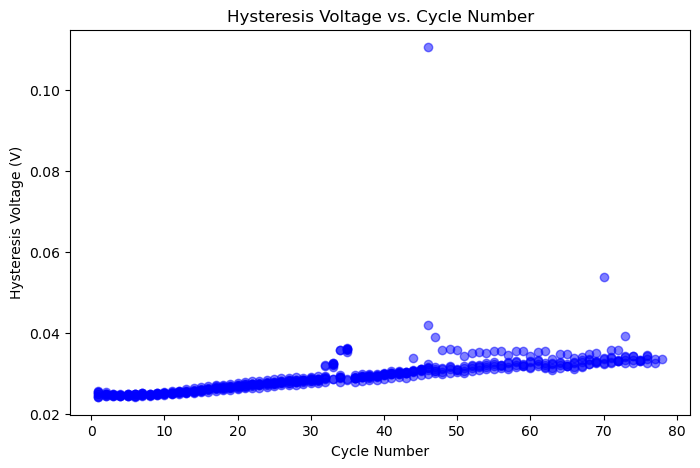

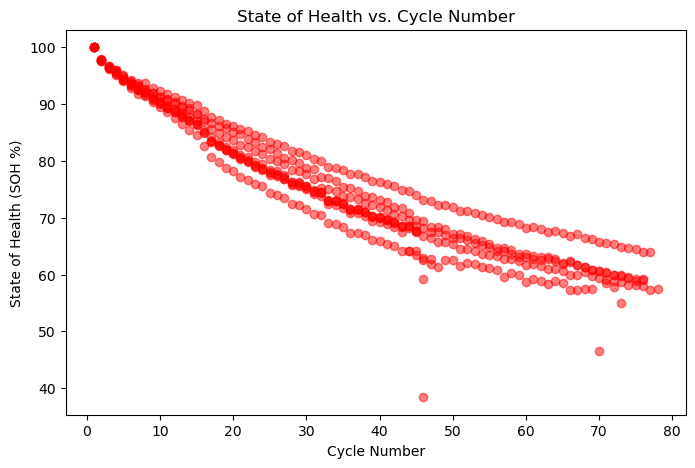

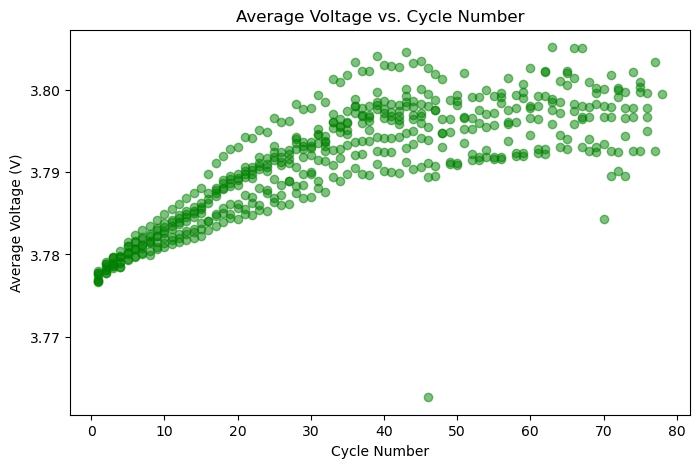

In [17]:
# ========================
# 11. Print Key Dataset Metrics (AFTER Model Training)
# ========================
print("\n Key Dataset Metrics (For Reference, Not Used in Modeling)")
print(f"Total rows in dataset: {len(full_data_filtered)}")
print(f"  Unique battery cells in dataset: {full_data_filtered['cell_number'].unique()}")
print(f"  Unique discharge cycles: {full_data_filtered['cycle_number'].nunique()}")
print(f"  Average Hysteresis Voltage: {hysteresis_df['hysteresis_voltage'].mean():.4f} V")

# Plot 1: Hysteresis Voltage vs. Cycle Number
plt.figure(figsize=(8, 5))  # Create a new figure
plt.scatter(grouped_OCV['cycle_number'], grouped_OCV['hysteresis_voltage'], alpha=0.5, color='blue')
plt.xlabel('Cycle Number')
plt.ylabel('Hysteresis Voltage (V)')
plt.title('Hysteresis Voltage vs. Cycle Number')

# Plot 2: State of Health (SOH) vs. Cycle Number
plt.figure(figsize=(8, 5))  # Create another new figure
plt.scatter(grouped_OCV['cycle_number'], grouped_OCV['SOH'], alpha=0.5, color='red')
plt.xlabel('Cycle Number')
plt.ylabel('State of Health (SOH %)')
plt.title('State of Health vs. Cycle Number')

# Plot 3: Voltage vs. Cycle Number
plt.figure(figsize=(8, 5))
plt.scatter(grouped_OCV['cycle_number'], grouped_OCV['avg_voltage'], alpha=0.5, color='green')
plt.xlabel('Cycle Number')
plt.ylabel('Average Voltage (V)')
plt.title('Average Voltage vs. Cycle Number')

# Show all plots at the end
plt.show()